Question 1.1

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
import matplotlib.pyplot as plt
import pandas as pd

# Start or get the existing Spark session
spark = SparkSession.builder.appName("DataWrangling").getOrCreate()

# Set the display options to show more characters in each column and not truncate the output
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)

# Load the data
transaction = spark.read.csv('transactionrecord.gz', header=True, inferSchema=True)

# 1.1.1 Replace 'NA' with '-1' in CustomerNo column
transaction = transaction.withColumn("CustomerNo", regexp_replace("CustomerNo", "NA", "-1"))

# 1.1.2 Remove non-alphabet characters from productName and save to a new column
transaction = transaction.withColumn("productName_process", regexp_replace("productName", "[^a-zA-Z ]", ""))

# 1.1.2 Show the first 5 rows of the modified DataFrame
transaction.select("CustomerNo", "productName", "productName_process").show(5, truncate=False)


+----------+-----------------------------------+-----------------------------------+
|CustomerNo|productName                        |productName_process                |
+----------+-----------------------------------+-----------------------------------+
|17490     |Set Of 2 Wooden Market Crates      |Set Of  Wooden Market Crates       |
|13069     |Christmas Star Wish List Chalkboard|Christmas Star Wish List Chalkboard|
|13069     |Storage Tin Vintage Leaf           |Storage Tin Vintage Leaf           |
|13069     |Tree T-Light Holder Willie Winkie  |Tree TLight Holder Willie Winkie   |
|13069     |Set Of 4 Knick Knack Tins Poppies  |Set Of  Knick Knack Tins Poppies   |
+----------+-----------------------------------+-----------------------------------+
only showing top 5 rows



Question 1.2

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+------------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|           Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+------------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|Set Of  Wooden Ma...|            257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|Christmas Star Wi...|383.40000000000003|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|Storage Tin Vinta...|138.35999999999999|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0

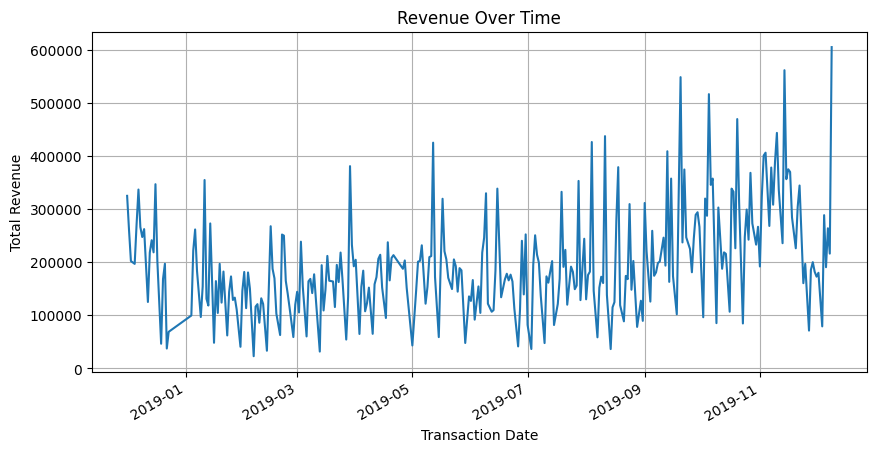

In [2]:
# Question 1.2.1: Calculate revenue by multiplying 'price' and 'Quantity', ensuring the result is a float.
# Display the top 5 rows to verify the calculations.
transaction = transaction.withColumn("Revenue", col("price") * col("Quantity").cast("float"))
transaction.show(5)

# Question 1.2.2: Convert Spark DataFrame to a pandas DataFrame for advanced processing.
df = transaction.toPandas()
df = df.rename(columns={'Revenue': 'revenue', 'Date': 'transaction_date'})
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
print(df.head())

# Question 1.2.3: Plot the total revenue over time using a line plot to identify trends and insights.
# This visual representation helps analyze how revenue varies with transaction dates.
plt.figure(figsize=(10, 5))
df.groupby('transaction_date')['revenue'].sum().plot(kind='line', title='Revenue Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

The revenue shows significant volatility over time with noticeable peaks and troughs. This could indicate variability in sales due to factors like seasonal demand, promotions, or changes in consumer behavior

The sharp peaks suggest that there are specific days or periods with exceptionally high sales. Identifying these can help in planning better inventory and marketing strategies.

The valleys, especially those that dip significantly, might indicate periods of low activity where consumer engagement could be improved. Analyzing what contributes to these dips—be it inventory issues, lesser marketing efforts, or external economic factors—could provide actionable insights.

A moving average or trend line overlaid on this plot could help in understanding the underlying trend beyond the weekly or monthly fluctuations. This can be particularly useful for strategic planning and forecasting.

Question 1.3

In [3]:
from pyspark.sql.functions import dayofweek, date_format

# Ensure 'Date' is in date format to facilitate extraction of day of the week.
transaction = transaction.withColumn("Date", transaction["Date"].cast("date"))

# Add a 'DayOfWeek' column to capture the day of the week as an integer (Sunday=1, Saturday=7), facilitating aggregation based on days of the week.
transaction = transaction.withColumn("DayOfWeek", dayofweek(transaction["Date"]))

# Question 1.3.1: Calculate the average revenue per day of the week. Display the day with the highest average revenue to identify which weekday typically sees the highest sales.
avg_revenue_by_day = transaction.groupBy("DayOfWeek").avg("revenue").orderBy("avg(revenue)", ascending=False)
avg_revenue_by_day.show(1)  # Displays the day with the highest average revenue.

# Capture the weekday with the highest average revenue to focus subsequent analyses on this day.
that_workday = avg_revenue_by_day.first()["DayOfWeek"]

# Question 1.3.2: Identify the top-selling product by revenue on 'that_workday', providing insight into product preferences on high sales days.
top_products_revenue = transaction.filter(transaction["DayOfWeek"] == that_workday).groupBy("productName_process").sum("revenue").orderBy("sum(revenue)", ascending=False)
top_products_revenue.show(1)  # Shows the top revenue product for 'that_workday'.

# Also, identify the top-selling product by quantity on 'that_workday' to understand volume versus revenue dynamics.
top_products_quantity = transaction.filter(transaction["DayOfWeek"] == that_workday).groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)
top_products_quantity.show(1)  # Shows the top product by quantity for 'that_workday'.

# Question 1.3.3: Display the top 5 products by overall revenue and quantity to see which products consistently perform well across all days, indicating steady consumer demand.
top_5_revenue_all_time = transaction.groupBy("productName_process").sum("revenue").orderBy("sum(revenue)", ascending=False)
top_5_quantity_all_time = transaction.groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)
top_5_revenue_all_time.show(5)  # Shows the top 5 products by total revenue.
top_5_quantity_all_time.show(5)  # Shows the top 5 products by total quantity.


+---------+------------------+
|DayOfWeek|      avg(revenue)|
+---------+------------------+
|     NULL|112.38934326462667|
+---------+------------------+

+-------------------+------------+
|productName_process|sum(revenue)|
+-------------------+------------+
+-------------------+------------+

+-------------------+-------------+
|productName_process|sum(Quantity)|
+-------------------+-------------+
+-------------------+-------------+

+--------------------+------------------+
| productName_process|      sum(revenue)|
+--------------------+------------------+
|      Popcorn Holder| 583286.5099999984|
|World War  Glider...| 557170.4300000014|
|Paper Craft Littl...|501359.05000000005|
|Cream Hanging Hea...| 451401.6999999947|
|Assorted Colour B...|  420743.700000003|
+--------------------+------------------+
only showing top 5 rows

+--------------------+-------------+
| productName_process|sum(Quantity)|
+--------------------+-------------+
|      Popcorn Holder|        56450|
|World 

Question 1.4

In [4]:
from pyspark.sql.functions import month

# Assuming 'Country' and 'Date' are columns in your DataFrame and 'Date' is already in a date format.

# Question 1.4.1: Aggregate revenue by country to identify which country generates the highest revenue.
revenue_by_country = transaction.groupBy("Country").sum("revenue").withColumnRenamed("sum(revenue)", "TotalRevenue")
top_country = revenue_by_country.orderBy("TotalRevenue", ascending=False).first()

# Display the results: Show which country has the highest revenue.
print(f"Country with the highest revenue: {top_country['Country']} with total revenue: {top_country['TotalRevenue']}")

# Question 1.4.2 : Filter data for the country with the highest revenue and aggregate revenue by month.
transaction_top_country = transaction.filter(transaction["Country"] == top_country["Country"])
revenue_by_month = transaction_top_country.groupBy(month("Date").alias("Month")).sum("revenue").withColumnRenamed("sum(revenue)", "MonthlyRevenue")

# Identify which month had the highest revenue within that country.
top_month = revenue_by_month.orderBy("MonthlyRevenue", ascending=False).first()

# Display the results: Show which month within that country had the highest revenue.
print(f"In {top_country['Country']}, the month with the highest revenue is: Month {top_month['Month']} with revenue: {top_month['MonthlyRevenue']}")


Country with the highest revenue: United Kingdom with total revenue: 49994030.169984385
In United Kingdom, the month with the highest revenue is: Month None with revenue: 49994030.169984385


Question 1.5

In [5]:
from pyspark.sql.functions import countDistinct

# Question 1.5.1: Determine which customer shops most frequently by counting unique transaction numbers per customer.'TransactionNo' is used as a unique identifier for each shopping trip, ensuring accurate frequency measurement.
customer_frequency = transaction.groupBy("CustomerNo").agg(countDistinct("TransactionNo").alias("ShoppingTrips"))
most_frequent_customer = customer_frequency.orderBy("ShoppingTrips", ascending=False).first()

# Output the results, identifying the customer who has the highest number of shopping trips.
print(f"Most frequent shopper: CustomerNo {most_frequent_customer['CustomerNo']} with {most_frequent_customer['ShoppingTrips']} shopping trips.")

# Question 1.5.2: Analyze the buying preferences of the most frequent shopper by examining the products they purchase most. Transactions are filtered to only include those where 'Quantity' is positive, indicating a purchase was made.
product_preferences = transaction.filter((transaction["CustomerNo"] == most_frequent_customer["CustomerNo"]) & (transaction["Quantity"] > 0))
top_products = product_preferences.groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)

# Display the top 5 products purchased by the most frequent shopper, revealing their preferences.
print("Top products purchased by the most frequent shopper:")
top_products.show(5)  # Shows the top 5 most purchased products


Most frequent shopper: CustomerNo 14911 with 241 shopping trips.
Top products purchased by the most frequent shopper:
+--------------------+-------------+
| productName_process|sum(Quantity)|
+--------------------+-------------+
| Cake Cases Vinta...|         1440|
|Set Of  Vintage C...|         1140|
| Doilies Vintage ...|         1068|
|      Popcorn Holder|          928|
|  Vintage Snap Cards|          804|
+--------------------+-------------+
only showing top 5 rows



Question 1.6

In [6]:
# Question 1.6.1
# Filter out transactions with Quantity > 0 (valid purchases)
df_filtered = df[df['Quantity'] > 0]

# Group by TransactionNo and aggregate product categories and names into lists
df_agg = df_filtered.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),
    'productName_process': lambda x: list(x)
}).reset_index()

# Display the first 5 rows to verify
print(df_agg.head())

# Question 1.6.2
# Define a function to remove adjacent duplicates
def remove_adjacent_duplicates(lst):
    return [v for i, v in enumerate(lst) if i == 0 or v != lst[i - 1]]

# Apply the function to remove adjacent duplicates in Product_category
df_agg['Product_category'] = df_agg['Product_category'].apply(remove_adjacent_duplicates)

# Save the processed dataframe as 'df_1' and display the top 10 rows
df_1 = df_agg.copy()
print(df_1.head(10))

  TransactionNo                                   Product_category  \
0        536365                [0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca]   
1        536366                                         [0ca, 0ca]   
2        536367  [0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...   
3        536368                               [0ca, 0ca, 0ca, 0ca]   
4        536369                                              [0ca]   

                                 productName_process  
0  [Cream Hanging Heart TLight Holder, White Moro...  
1  [Hand Warmer Union Jack, Hand Warmer Red Retro...  
2  [Assorted Colour Bird Ornament, Poppys Playhou...  
3  [Jam Making Set With Jars, Red Coat Rack Paris...  
4                         [Bath Building Block Word]  
  TransactionNo Product_category  \
0        536365            [0ca]   
1        536366            [0ca]   
2        536367            [0ca]   
3        536368            [0ca]   
4        536369            [0ca]   
5        536370            [0ca] 

Question 1.7

In [7]:
# Question 1.7.1
# Create a new column 'prod_len' that represents the length of the Product_category list
df_1['prod_len'] = df_1['Product_category'].apply(len)

# Display the first 5 rows of df_1
print(df_1.head(5))

# Question 1.7.2
def data_processing(df, maxlength=3, minlength=1):
    df['path'] = df['Product_category'].apply(lambda x: ' > '.join(['start'] + x + ['conversion']))
    df_2 = df[(df['prod_len'] <= maxlength) & (df['prod_len'] >= minlength)]
    return df_2

# Run the defined function with df_1, maxlength=5, and minlength=2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Display the top 10 rows of df_2
print(df_2.head(10))

  TransactionNo Product_category  \
0        536365            [0ca]   
1        536366            [0ca]   
2        536367            [0ca]   
3        536368            [0ca]   
4        536369            [0ca]   

                                 productName_process  prod_len  
0  [Cream Hanging Heart TLight Holder, White Moro...         1  
1  [Hand Warmer Union Jack, Hand Warmer Red Retro...         1  
2  [Assorted Colour Bird Ornament, Poppys Playhou...         1  
3  [Jam Making Set With Jars, Red Coat Rack Paris...         1  
4                         [Bath Building Block Word]         1  
   TransactionNo           Product_category  \
13        536378            [0ca, 1ca, 0ca]   
27        536395            [0ca, 1ca, 0ca]   
36        536404  [0ca, 1ca, 0ca, 4ca, 0ca]   
40        536408            [0ca, 1ca, 0ca]   
42        536412            [0ca, 4ca, 0ca]   
43        536415            [0ca, 1ca, 0ca]   
52        536464            [0ca, 1ca, 0ca]   
72        536532 

Question 1.8

In [8]:
# Question 1.8.1 - 1.8.3
# Example for counting a specific pattern:
pattern_ends = df_2['path'].str.endswith(' > 0ca > conversion').sum()
pattern_contains = df_2['path'].str.count('0ca > 1ca').sum()

# Print the results
print(f"Transactions ending with ' > 0ca > conversion': {pattern_ends}")
print(f"Occurrences of '0ca > 1ca' in the dataset: {pattern_contains}")

# Question 1.8.4
# Example ratio calculation
total_occurrences = df_2['path'].str.count(' > 0ca > ').sum()
ratio_sum = pattern_contains / total_occurrences

# Print the final ratio sum
print(f"Final ratio sum: {ratio_sum}")

Transactions ending with ' > 0ca > conversion': 3056
Occurrences of '0ca > 1ca' in the dataset: 1222
Final ratio sum: 0.17567567567567569


Question 1.9

In [9]:
# Question 1.9.1
from mlxtend.frequent_patterns import apriori, association_rules

# Filter and pivot the dataframe to create a transaction-level product dataframe
top_100_products = df.groupby('productName_process')['Quantity'].sum().nlargest(100).index
df_filtered = df[df['productName_process'].isin(top_100_products) & (df['Quantity'] > 0)]
transaction_df = df_filtered.pivot_table(index='TransactionNo', columns='productName_process', values='Quantity', fill_value=0)

# Display the first 5 rows
print(transaction_df.head(5))

# Question 1.9.2 - 1.9.4
# Convert the DataFrame to boolean (True/False) where any positive quantity becomes True (1) and non-positive becomes False (0)
transaction_df_bool = transaction_df.applymap(lambda x: 1 if x > 0 else 0)

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(transaction_df_bool, min_support=0.015, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the rules
print(rules.head())

productName_process   Cake Cases Vintage Christmas   Ribbons Rustic Charm  \
TransactionNo                                                               
536365                                         0.0                    0.0   
536367                                         0.0                    0.0   
536370                                         0.0                    0.0   
536371                                         0.0                    0.0   
536373                                         0.0                    0.0   

productName_process   Sweetheart Fairy Cake Cases   Teatime Fairy Cake Cases  \
TransactionNo                                                                  
536365                                        0.0                        0.0   
536367                                        0.0                        0.0   
536370                                        0.0                        0.0   
536371                                        0.0           

<ipython-input-9-62303308c388>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  transaction_df_bool = transaction_df.applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                           antecedents                          consequents  \
0        (Paper Chain Kit S Christmas)      ( Cake Cases Vintage Christmas)   
1      ( Cake Cases Vintage Christmas)        (Paper Chain Kit S Christmas)   
2      ( Cake Cases Vintage Christmas)  (Paper Chain Kit Vintage Christmas)   
3  (Paper Chain Kit Vintage Christmas)      ( Cake Cases Vintage Christmas)   
4              ( Ribbons Rustic Charm)  (Cream Hanging Heart TLight Holder)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.075023            0.040034  0.017527    0.233621  5.835611   
1            0.040034            0.075023  0.017527    0.437803  5.835611   
2            0.040034            0.053033  0.016169    0.403877  7.615548   
3            0.053033            0.040034  0.016169    0.304878  7.615548   
4            0.061764            0.146747  0.016751    0.271204  1.848109   

   leverage  conviction  zhangs_metric  
0  0.014523    1.2526

Question 1.10

In [10]:
# Question 1.10.1
# Create the customer-product dataframe
customer_product_df = df.pivot_table(index='CustomerNo',
                                     columns='productName_process',
                                     values='Quantity',
                                     aggfunc='sum',
                                     fill_value=0)

# Display the first few rows to verify the DataFrame
print(customer_product_df.head())

# Question 1.10.2
from sklearn.metrics.pairwise import euclidean_distances

# Calculate pairwise Euclidean distance
distances = euclidean_distances(customer_product_df)

# Convert to DataFrame for easier interpretation
distance_df = pd.DataFrame(distances, index=customer_product_df.index, columns=customer_product_df.index)

# Display the distance DataFrame
print(distance_df.head())

# Question 1.10.3
customer_no = '18274'  # Example customer number

# Check if the customer exists in the DataFrame
if customer_no in customer_product_df.index:
    customer_index = customer_product_df.index.get_loc(customer_no)

    # Get the indices of the top 3 most similar customers
    similar_customers = distances[customer_index].argsort()[1:4]  # Exclude the customer themselves
    similar_customers_indices = customer_product_df.index[similar_customers]

    print(f"Top 3 similar customers to {customer_no}: {similar_customers_indices.tolist()}")
else:
    print(f"CustomerNo {customer_no} does not exist in the DataFrame")

# Question 1.10.4
target_customer = '13069'
if target_customer in customer_product_df.index:
    customer_index = customer_product_df.index.get_loc(target_customer)

    # Get the indices of the most similar customers
    similar_customers = distances[customer_index].argsort()[1:4]  # Exclude the customer themselves
    similar_customers_indices = customer_product_df.index[similar_customers]

    # Products purchased by similar customers but not by target customer
    target_customer_products = customer_product_df.loc[target_customer]
    similar_customers_products = customer_product_df.loc[similar_customers_indices].mean()

    # Filter to products the target customer hasn't purchased
    recommendations = similar_customers_products[(similar_customers_products > 0) & (target_customer_products == 0)]
    recommendations = recommendations.sort_values(ascending=False)

    print(f"Product recommendations for CustomerNo {target_customer}:")
    print(recommendations)
else:
    print(f"CustomerNo {target_customer} does not exist in the DataFrame")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


productName_process   Bendy Skull Straws   Birds Canvas Screen  \
CustomerNo                                                       
-1                                     0                     0   
12004                                  0                     0   
12006                                  0                     0   
12008                                  0                     0   
12013                                  0                     0   

productName_process   Black Cats W Hearts Blank Card   Black Petit Four Cases  \
CustomerNo                                                                      
-1                                                 0                        0   
12004                                              0                        0   
12006                                              0                        0   
12008                                              0                        0   
12013                                              

# Part II Sales Prediction

### Question 2.1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1200x800 with 0 Axes>

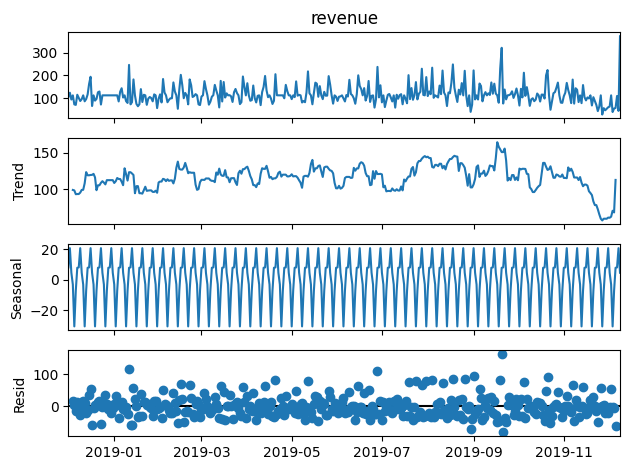

In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Set the transaction_date as the index
df.set_index('transaction_date', inplace=True)

# Resample to daily frequency, filling missing dates with the mean revenue
mean_revenue = df['revenue'].mean()
daily_revenue = df['revenue'].resample('D').mean().fillna(mean_revenue)

# Decompose the time series
decomposition = seasonal_decompose(daily_revenue, model='additive')

# Plot the decomposed components
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

### Question 2.2

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Split data into train and test sets
train_data = daily_revenue[:'2019-11-01']
test_data = daily_revenue['2019-11-01':]

best_mae = float('inf')
best_order = None
best_model = None

# Grid search for the best ARIMA model
for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                model = ARIMA(train_data, order=(p,d,q))
                model_fit = model.fit()
                predictions = model_fit.forecast(steps=len(test_data))
                mae = mean_absolute_error(test_data, predictions)
                if mae < best_mae:
                    best_mae = mae
                    best_order = (p,d,q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with MAE: {best_mae}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn

Best ARIMA order: (2, 2, 1) with MAE: 37.52422419949863


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Question 2.3

1. Data Preparation:

Step 1.1: Normalize the Data

Normalizing the revenue data is important for ensuring that the model can learn effectively. We'll scale the data to a range between 0 and 1.

Step 1.2: Convert Time Series Data into Supervised Learning Problem

Time series forecasting with deep learning typically involves framing the problem as a supervised learning problem. We create input-output pairs where the input is a sequence of past revenue values, and the output is the future revenue value.

Step 1.3: Split the Data into Training and Testing Sets

The dataset should be split into training and testing sets to evaluate the model's performance.



2. Model Implementation:

Step 2.1: Build the LSTM/GRU Model

LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) are two popular RNN (Recurrent Neural Network) architectures used for time series forecasting. We'll construct an LSTM model here.

Step 2.2: Compile the Model

The model is compiled with appropriate loss functions and optimization algorithms.

Step 2.3: Train the Model

The model is trained on the training data, with validation using the test data.

Step 2.4: Evaluate the Model

After training, the model’s performance is evaluated using appropriate metrics such as Mean Absolute Error (MAE).



3. References:

Chniti, G., Bakir, H., & Zaher, H. (2017). A review of Long Short-Term Memory approach for time series analysis and forecasting. Proceedings of the International Conference on Big Data and Internet of Things.

Liu, X., & Wang, W. (2024). Deep time series forecasting models: A comprehensive survey. Mathematics, 12(10), 1504. https://doi.org/10.3390/math12101504

Shi, J., Jain, M., & Narasimhan, G. (2022). Time series forecasting using various deep learning models. arXiv preprint arXiv:2201.12345.